In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

device(type='mps')

In [3]:
data = pd.read_csv(
    "../Flu Shot Learning Predict H1N1 and Seasonal Flu Vaccines/fixed_training_set.csv"
)
data = data.drop(columns=["respondent_id"])

training_dataset = np.array(data, dtype=np.float32)

In [4]:
class FluShotData(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
class Model(nn.Module):
    def __init__(self, in_features, out_features=1, hidden_features=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features, hidden_features, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features, dtype=torch.float32),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [6]:
def draw_loss(train_loss):
    plt.plot(
        np.arange(len(train_loss)),
        train_loss,
        color=np.random.rand(
            3,
        ),
        label="train loss",
    )
    plt.legend(loc=0, ncol=1)
    plt.xlabel("iternations")
    plt.ylabel("loss")
    # plt.show()


def train(model: Model, data, threshold, lr):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.BCELoss()
    loss_list = []
    for epoch in range(threshold):
        loss_epoch = 0
        for i, batch in enumerate(data):
            optimizer.zero_grad()
            x: Tensor = batch[:, :-2].to(device)
            y: Tensor = batch[:, -2:].to(device)
            y_pred: Tensor = model(x)
            loss: Tensor = criterion(y_pred, y)
            loss.backward()
            loss_epoch += loss.item()
            optimizer.step()
        loss_epoch /= len(data)
        print(f"Epoch: {epoch}, Loss: {loss_epoch}")
        loss_list.append(loss_epoch)
        lr_scheduler.step()

    draw_loss(loss_list)

Epoch: 0, Loss: 0.6161267478415307
Epoch: 1, Loss: 0.5421570418997014
Epoch: 2, Loss: 0.4905018685980046
Epoch: 3, Loss: 0.4597011817262528
Epoch: 4, Loss: 0.4446426877316008
Epoch: 5, Loss: 0.4355859160423279
Epoch: 6, Loss: 0.43046390376192456
Epoch: 7, Loss: 0.4263127002310246
Epoch: 8, Loss: 0.42325929251122985
Epoch: 9, Loss: 0.42144591440545753
Epoch: 10, Loss: 0.4196854119605206
Epoch: 11, Loss: 0.41855977190301774
Epoch: 12, Loss: 0.41828254245697183
Epoch: 13, Loss: 0.4174538964920856
Epoch: 14, Loss: 0.41728909979475304
Epoch: 15, Loss: 0.4163258024986754
Epoch: 16, Loss: 0.41605379543405896
Epoch: 17, Loss: 0.4157997528289227
Epoch: 18, Loss: 0.41568785715610423
Epoch: 19, Loss: 0.41493598768051637
Epoch: 20, Loss: 0.4145017659410517
Epoch: 21, Loss: 0.4140587975370123
Epoch: 22, Loss: 0.41385983723275205
Epoch: 23, Loss: 0.4136023223400116
Epoch: 24, Loss: 0.4132968136604796
Epoch: 25, Loss: 0.4130876533528592
Epoch: 26, Loss: 0.41282832812755665
Epoch: 27, Loss: 0.41268006

[(0.8711944742484836, 0.848742272676183),
 (0.8613001417729963, 0.8512292528022591),
 (0.8492922964730841, 0.8466599773557786),
 (0.8616527696817633, 0.8583677806699305),
 (0.8536886884169903, 0.8563614356087261),
 (0.8625631758345088, 0.8546006200193135),
 (0.8702139130551259, 0.8602957978425825),
 (0.8666699136089427, 0.8548418445294208),
 (0.8560590423349712, 0.8546117451887052),
 (0.8466655791650141, 0.8554111856106883)]

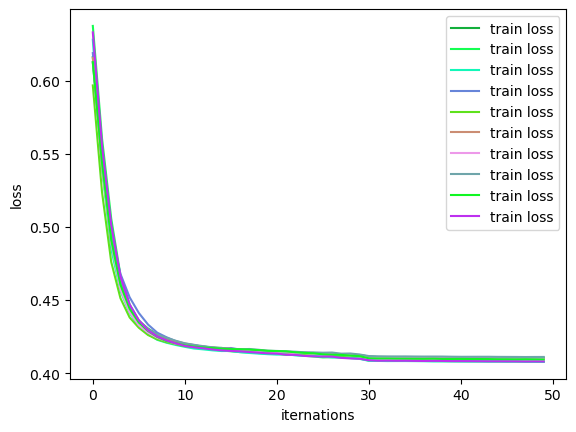

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=10)

roc_list = []


# Calculate Accuracy
def accuracy(real_val, predict_val):
    assert len(real_val) == len(predict_val)
    correct = [1 if x == y else 0 for (x, y) in zip(real_val, predict_val)]
    return np.sum(correct) / len(real_val)


for train_set, valid_set in kf.split(training_dataset):
    train_data = training_dataset[train_set]
    train_data = DataLoader(
        FluShotData(train_data),
        batch_size=512,
        shuffle=True,
    )
    model = Model(training_dataset.shape[1] - 2, out_features=2).to(device)
    train(model, train_data, 50, lr=0.001)

    valid_data = training_dataset[valid_set]
    model.eval()
    y_pred = (
        model(torch.from_numpy(valid_data[:, :-2]).to(device)).cpu().detach().numpy()
    )
    roc_list.append(
        (
            roc_auc_score(valid_data[:, -2], y_pred[:, -2]),
            roc_auc_score(valid_data[:, -1], y_pred[:, -1]),
        )
    )
    # y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])
    # accuracy_list.append(accuracy(valid_data[:, -1], y_pred))

roc_list

####  预测测试集

Epoch: 0, Loss: 0.6298110218758278
Epoch: 1, Loss: 0.5552483822437043
Epoch: 2, Loss: 0.49454036545246205
Epoch: 3, Loss: 0.45834803834874577
Epoch: 4, Loss: 0.4412054159539811
Epoch: 5, Loss: 0.4325733914020214
Epoch: 6, Loss: 0.42699191418099913
Epoch: 7, Loss: 0.4233391887329994
Epoch: 8, Loss: 0.4213692996096104
Epoch: 9, Loss: 0.41939781828129546
Epoch: 10, Loss: 0.4181876670806966
Epoch: 11, Loss: 0.4172072619833845
Epoch: 12, Loss: 0.41669881660887537
Epoch: 13, Loss: 0.41619767026698334
Epoch: 14, Loss: 0.4153322114589367
Epoch: 15, Loss: 0.41480945526285373
Epoch: 16, Loss: 0.41408683137690766
Epoch: 17, Loss: 0.4138656588310891
Epoch: 18, Loss: 0.4133750339771839
Epoch: 19, Loss: 0.41308689624705214
Epoch: 20, Loss: 0.4128091944024918
Epoch: 21, Loss: 0.4134606015174947
Epoch: 22, Loss: 0.41309820337498443
Epoch: 23, Loss: 0.4119246995195429
Epoch: 24, Loss: 0.4116826869071798
Epoch: 25, Loss: 0.4117413638754094
Epoch: 26, Loss: 0.41111555124850985
Epoch: 27, Loss: 0.41097283

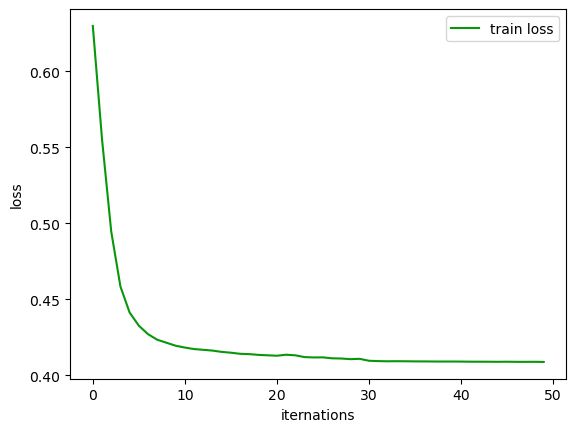

In [8]:
test_dataset = pd.read_csv(
    "../Flu Shot Learning Predict H1N1 and Seasonal Flu Vaccines/fixed_test_set.csv"
)

id_start = test_dataset["respondent_id"][0]

for id, item in enumerate(test_dataset["respondent_id"]):
    assert id + id_start == item

test_dataset = test_dataset.drop(columns=["respondent_id"])
test_dataset = np.array(test_dataset, dtype=np.float32)

model = Model(training_dataset.shape[1] - 2, out_features=2).to(device)
train(model, train_data, 50, lr=0.001)

model.eval()
y_pred = model(torch.from_numpy(test_dataset).to(device)).cpu().detach().numpy()
y_pred = pd.DataFrame(
    {
        "respondent_id": np.arange(id_start, id_start + y_pred.shape[0]),
        "h1n1_vaccine": y_pred[:, -2],
        "seasonal_vaccine": y_pred[:, -1],
    }
)
y_pred.to_csv("submission.csv", index=False)